# Imports

In [1]:
#%matplotlib notebook
%matplotlib inline 

import matplotlib
import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import holoviews as hv

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pickle as pk
from time import time
import io

import datetime
import sys

from IPython.display import display, HTML, clear_output
from ipywidgets import widgets
from ipywidgets.widgets import interact, interactive, interactive_output, fixed, Widget 
from ipywidgets.widgets import IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, Checkbox, RadioButtons, Dropdown, Button
from ipywidgets.widgets import HBox, VBox, Label,Text

#  !pip3 install mpld3
# import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
# from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from Cluster import * 

In [3]:
bd = BaseData('data_all_base')

reading in data from data_all_base ...
elapsed:  7.0274670124053955


In [4]:
# run 
# clusdtypes should be in ['JRP1','ORP1','JWP1','OWP1','JRT1','ORT1','JWT1','OWT1']
# database JHU/OWID  (J/O) 
# report_correct T or F   (R/W)
# syncat peak/thresh  (P/T)
clusdtype='JRT1'
ClData = get_cluster_data(clusdtype)

reading in data from ./pks/data_cluster_JRT1.pk ...


In [5]:
exec(open('ClusterFit.py','r').read())

In [6]:
# changed to use model_fits_age : this is backwards compatible and only loads data if needed
import data_config
data_config.data_loaded = True

from model_fits_age import *  # including ModelFit class definition. 

data already loaded, so no "from data import *" required.
making the models...
SC2UIR
SC2FIR
SC3FEIR
SEI3R
SC3FEI3R
SC2FUIR
SC3FUEI3R
done with the models.


In [7]:
%load_ext autoreload
%autoreload 2

import ModelFit #import the module here, so that it can be reloaded.

#exec(open('ModelFit.py','r').read())
#import importlib
#importlib.reload(ModelFit)
from ModelFit import *

In [8]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] > 0]
print(len(countries),'countries with population data')
countries_zp = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] == 0]
print('common countries without population data',countries_zp)
cluster_countries = [c for c in ClData.clusdata_all['deaths']]
print(len(cluster_countries),'cluster countries')


198 countries with population data
common countries without population data []
76 cluster countries


In [9]:
[x for x in fullmodels]

['SC2UIR', 'SC2FIR', 'SC3FEIR', 'SEI3R', 'SC3FEI3R', 'SC2FUIR', 'SC3FUEI3R']

In [10]:
agemodels

['SIR',
 'SC2IR',
 'SC2FIR',
 'SEIR',
 'SC3EIR',
 'SC3FEIR',
 'SEI3R',
 'SC3EI3R',
 'SC3FEI3R',
 'SC3UEI3R',
 'SC3FUEI3R']

# Experiments with tolerance, `reduce_fcn`

* Experiments here use Fit_Dash notebook, section "SliderFit with fit_trace".

* The sequence of experiments is listed in _reverse order_.  (Bottom cell is first experiment).

* Important note:  reduce_fcn arg is _not used_ in case of `fit_method='leastsq'`.  The experiments below are mostly using Nelder.

* **Workflow**:  hardcode reduce_fcn in ModelFit.py line 1073, rely on %%autoreload, run the 2 cells below.

In [14]:
chosen_model = 'SC3FUEI3R'
chosen_country = 'Australia'
chosen_paramtype = 'ode'
chosen_age = 1

countries_common = bd.countries_common
paramtypes = ['base','ode']
datasrcs = ['jhu','owid']
agegroups = [1,4,8,16]

modelnames_widget = Dropdown(options=possmodels,description='model',layout={'width': 'max-content'},value=chosen_model)
modelage_widget = Dropdown(options=agegroups,description='age grps',layout={'width': 'max-content'},value=chosen_age)
countries_widget = Dropdown(options=countries_common,description='countries',layout={'width': 'max-content'},value=chosen_country)
paramtypes_widget = Dropdown(options=paramtypes,description='param class',style={'description_width': 'initial'}, layout={'width': 'max-content'},value=chosen_paramtype)
runid_widget = Text(value=None,placeholder='Enter run id',description='Run_id:',disabled=False)
datasrcs_widget = RadioButtons(options=datasrcs,value='jhu',description='data src',disabled=False,layout={'width': 'max-content'}) 


MyModel = None
first = True
def fit_trace(modelname,agestructure,datasrc,country,paramtype,run_id):
    global bd,MyModel,params_init_min_max,params_init_min_max_slider,fit_new_params_widget
    global sliders_widgets,sliderparams,sliders,bsliders,slbox,f2s_button,s2f_button
    global first 
    if MyModel is None:
        MyModel = SliderFitWrap(basedata=bd,fit_targets=['confirmed','deaths'],
                    modelnames_widget=modelnames_widget,modelage_widget=modelage_widget,countries_widget=countries_widget,
                    datasrcs_widget=datasrcs_widget,paramtypes_widget=paramtypes_widget,runid_widget=runid_widget);
    if int(agestructure) > 1 and modelname in agemodels :   # modelname value from widget
        modelname_a = modelname+'_A'+str(agestructure)
    elif int(agestructure) > 1:  # age structure not yet implemented for this model type
        modelname_a = modelname
        agestructure=1
        modelage_widget.value = agestructure
    else:
        modelname_a = modelname
    modelnames_widget.value = modelname_a
        
    if (MyModel.modelname != modelname_a) or (MyModel.param_class != paramtype):  # new modelname, param_type => build a new MyModel
        MyModel = SliderFitWrap(basedata=bd,fit_targets=['confirmed','deaths'],
                    modelnames_widget=modelnames_widget,modelage_widget=modelage_widget,countries_widget=countries_widget,
                    datasrcs_widget=datasrcs_widget,paramtypes_widget=paramtypes_widget,runid_widget=runid_widget);
    if MyModel.country != country or MyModel.data_src != datasrc :   # value from widget
        MyModel.setup_data(country,datasrc)
        MyModel.transfer_cur_to_plot();
        # MyModel = SliderFit(modelname=modelname,basedata=bd,country=country,run_id=run_id,data_src=datasrc,param_class=paramtype)
    display(MyModel.slbox)
#    if first:
#        display(MyModel.slbox)
#        first = False
    #ax=MyModel.solveplot(['deaths','confirmed','caution_fraction','economy'],
    #                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
    #                  mag={'deaths':30.},newplot=True,figsize=(8,5));

#country_fit_trace = interactive_output(fit_trace,{'modelname':modelnames_widget,'fittype':fittypes_widget,'datasrc':datasrcs_widget,'dataname':datanames_widget,'country':countries_widget});
country_fit_trace = interactive_output(fit_trace,{'modelname':modelnames_widget,'agestructure':modelage_widget,
                                                  'datasrc':datasrcs_widget,'country':countries_widget,'paramtype':paramtypes_widget,
                                                  'run_id':runid_widget});

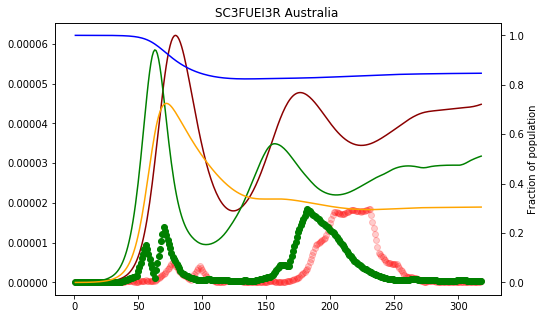

In [15]:
MyModel.solveplot(['deaths','confirmed','caution_fraction','economy'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.},newplot=True,figsize=(8,5))
MyModel.fig

In [16]:
choicebox = HBox([modelnames_widget, modelage_widget,countries_widget,datasrcs_widget,paramtypes_widget,runid_widget])
sbox = VBox([choicebox,MyModel.slbox])
sbox = VBox([choicebox,country_fit_trace])
display(sbox)

# John's experiments with threshold statistics on absolute value of residuals

## Medial threshold
Using Nelder and tol -3 with pc_thresh=50, all params. do fit twice (improvement on second time). Manually slide beta_1 up to 0.36. refit. Fitting uses log (1+x) scaling not linear.


## Quartile threshold



# Norman's experiments with threshold statistics directly on signed residuals

## Try hard threshold

For differences $d$, if $d_m = \rm{median}(d)$, let $\hat{d_i} = 0$ if $d_i<d_m$, $1$ otherwise.

Then

med_hard($d$) = $\sqrt{\sum_i \hat{d_i}^2}$

Result using med_hard() (pretty terrible.  resid ~9x default) :

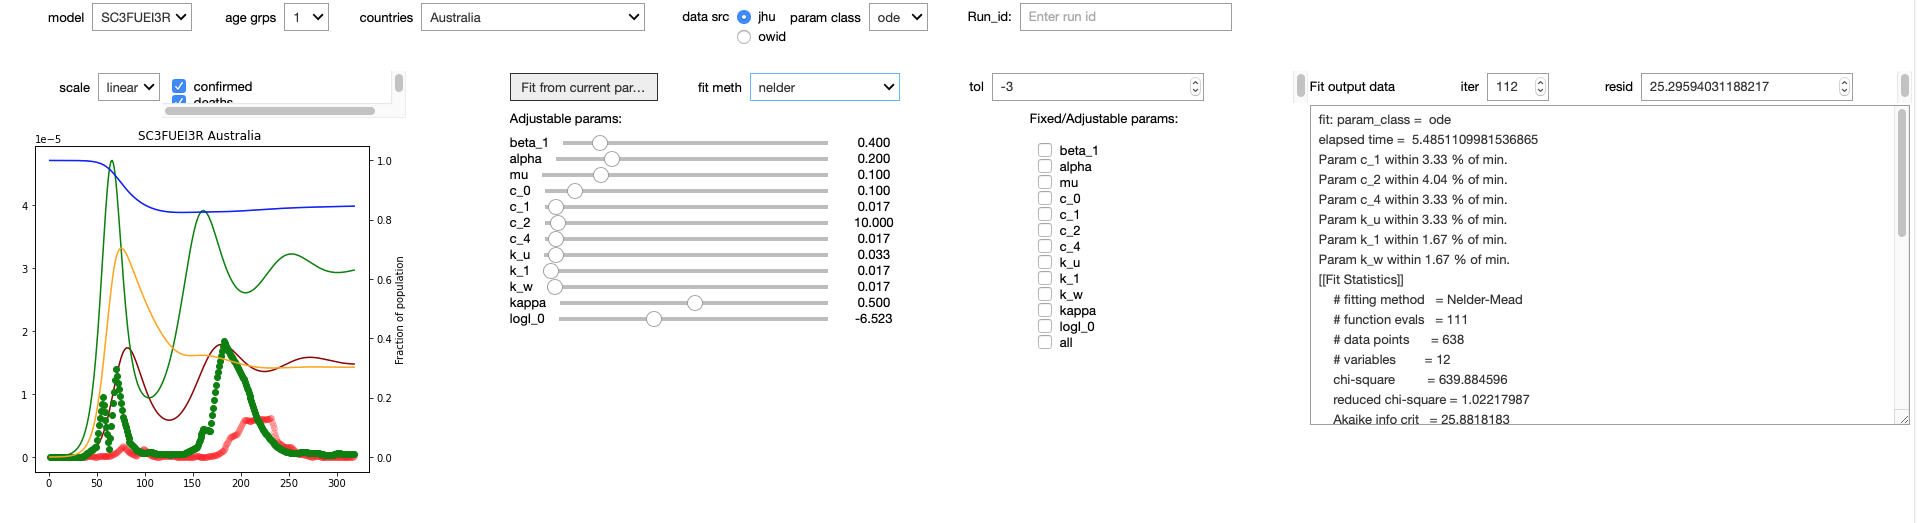

## mess with tolerance

Change in tolerance (using `tol_widget`).  NB from [docs on lmfit minimizer](https://lmfit.github.io/lmfit-py/fitting.html#using-the-minimizer-class):
* for leastsq, there are two tolerance args

| tolerance  | Default Value | Description |
| :-----------|---------------|-------------|
| xtol | 1.e-7 | Relative error in the approximate solution |
| ftol | 1.e-7 | Relative error in the desired sum of squares |

* for most other fit methods (nelder, etc), there is one tolerance arg:

| tolerance  | Default Value | Description |
| :-----------|---------------|-------------|
| tol | 1.e-7 | fitting and parameter tolerance |

Nelder

Same as below, but with tol=-3  (=> 0.001)

Very similar dynamics. Slightly smaller residual.

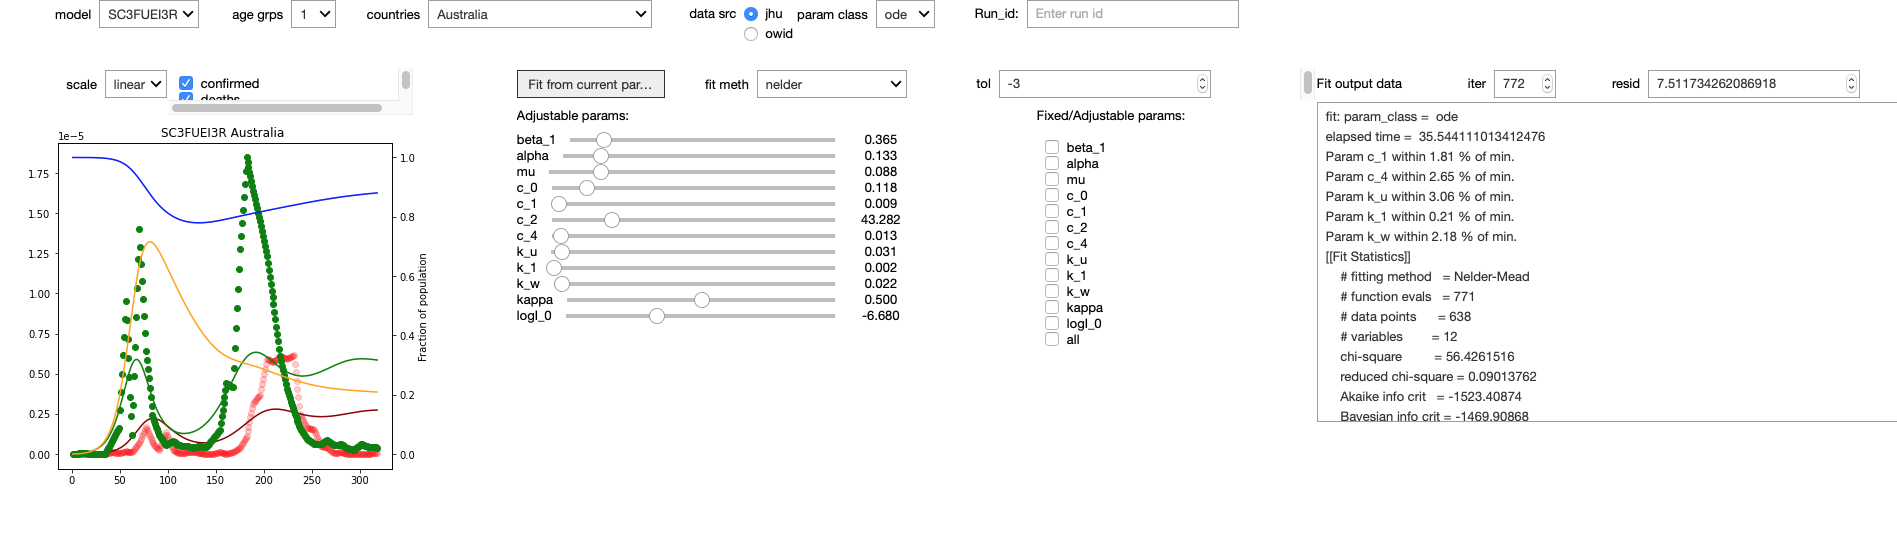

## try median threshold for `reduce_fcn`

Nelder

For differences $d$, if $d_m = \rm{median}(d)$, let $\hat{d} = \min(d,d_m)$.

Then

med_thresh($d$) = $\sqrt{\sum_i \hat{d_i}^2}$




Result using med_thresh():


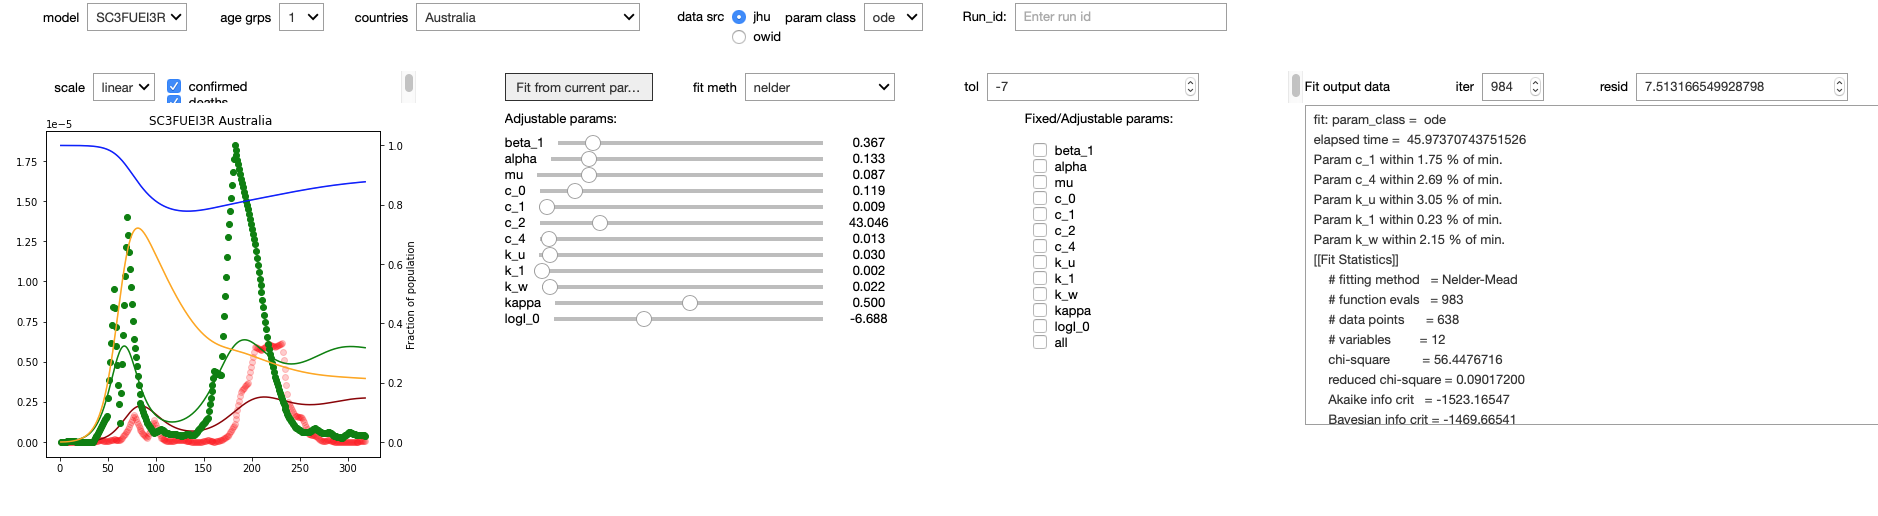

## Test that manually computed gives same as default

Nelder

`reduce_fcn=lsq`:  Same as default.


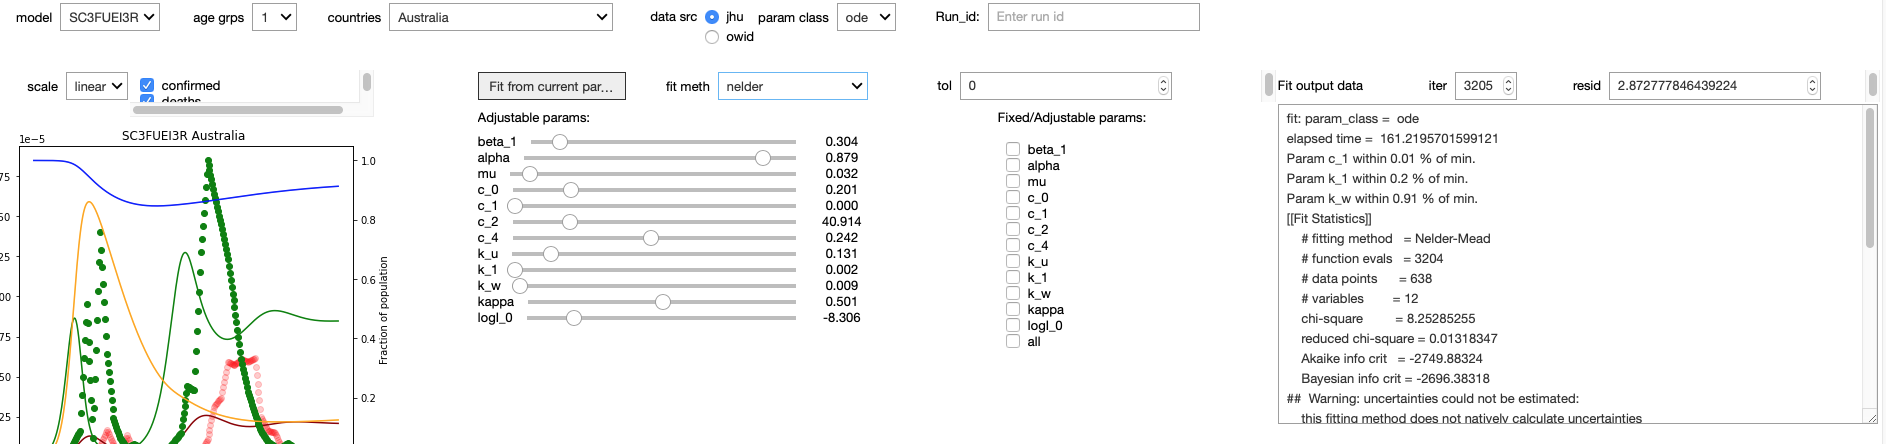


## Baseline: Nelder with default reduce_fcn (=>LSQ)

Nelder

default reduce_fcn:

* smaller residual than leastsq.
* worse looking dynamics.
* **????**

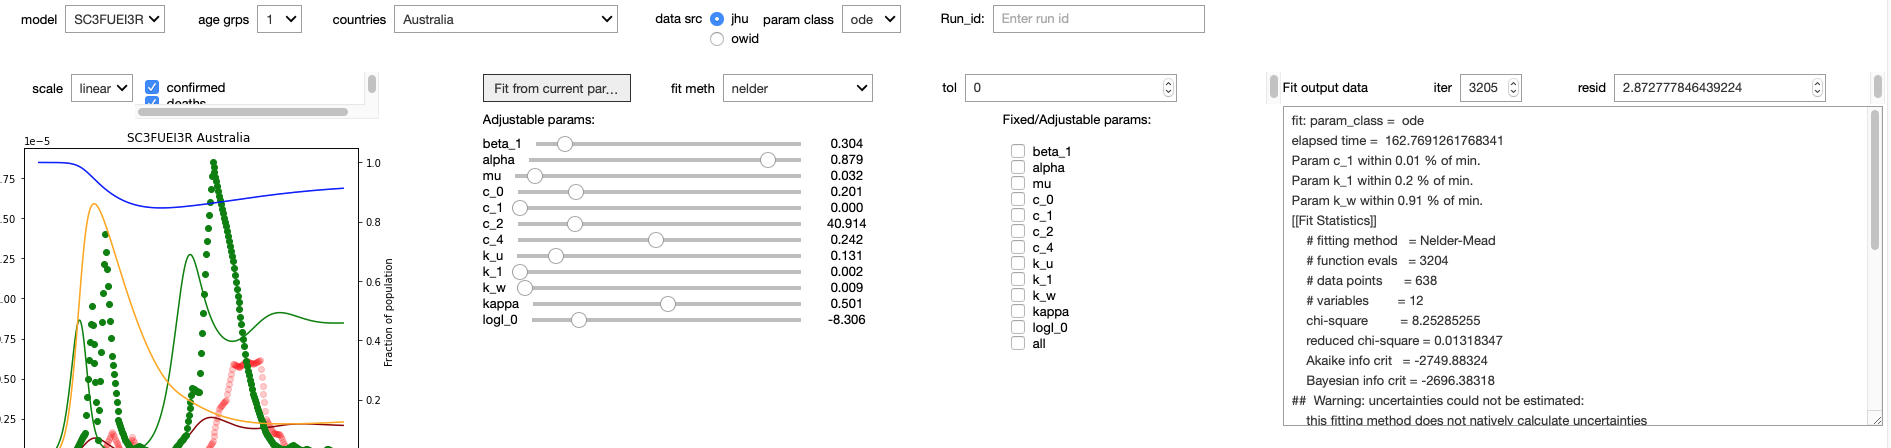

## Even baser baseline: leastsq.

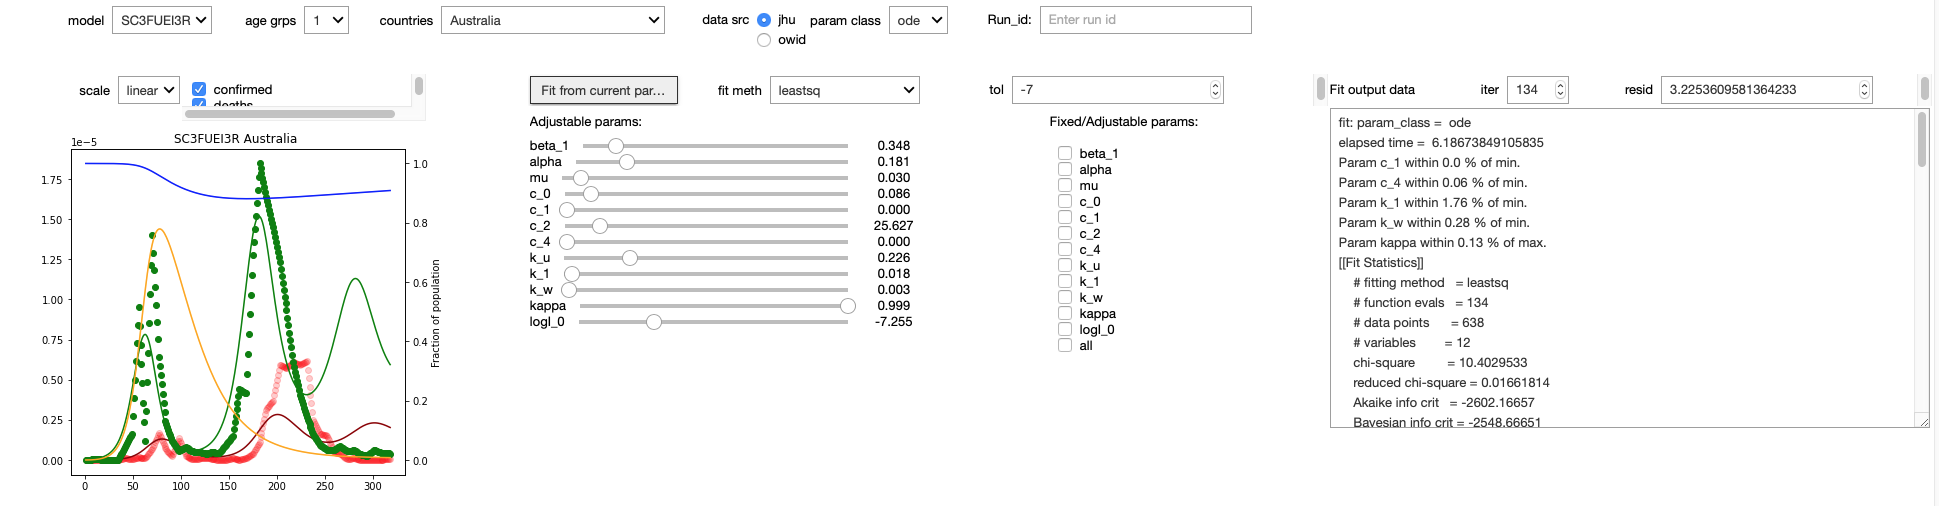

In [41]:
MyModel.params

{'beta_1': 0.3477110929675282,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.18136956606138316,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.029687192060047107,
 'c_0': 0.0863913540040141,
 'c_1': 1.5437546796448487e-08,
 'c_2': 25.626689405807912,
 'c_4': 0.0003002735909354015,
 'k_u': 0.22564666153412577,
 'k_1': 0.017619249045809304,
 'k_w': 0.0028278169769091477,
 'kappa': 0.9986647219838434,
 'N': 1}

In [49]:
MyModel.fit_targets

['confirmed', 'deaths']

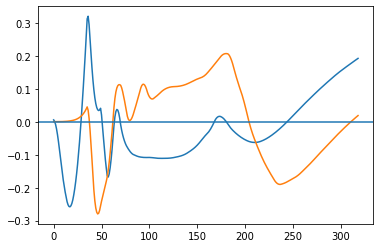

In [65]:
# run fit from current above before trying to execute this cell
[plt.plot(MyModel.logresid[x]) for x in MyModel.logresid]
plt.axhline(0);

In [15]:
print(scipy.__version__,np.__version__)

1.5.4 1.19.4


In [13]:
# temporary cell to debug text display
widgets.IntText(value=0,description='iter',disabled=False,style= {'description_height':'50px'},layout=Layout(display='flex',flex_flow='row',height='100%',margin='0px 0px 0px 0px'))

IntText(value=0, description='iter', layout=Layout(display='flex', flex_flow='row', height='100%', margin='0px…

In [62]:
# temporary cell to debug text display
style= {'description_height':'100%'}
widgets.IntText(value=0,description='iter',disabled=False,style=style,layout=Layout(height='100%',vertical_align='middle'))

IntText(value=0, description='iter', layout=Layout(height='100%'))

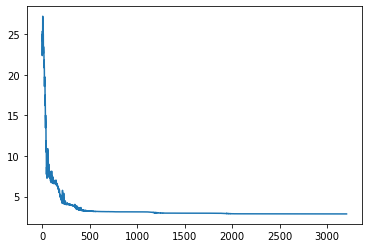

In [66]:
x,y = np.transpose(np.array(MyModel.residall))
plt.plot(x,y)

In [68]:
len(MyModel.paramall)

3205

['beta_1', 'alpha', 'mu', 'c_0', 'c_1', 'c_2', 'c_4', 'k_u', 'k_1', 'k_w', 'kappa', 'logI_0']


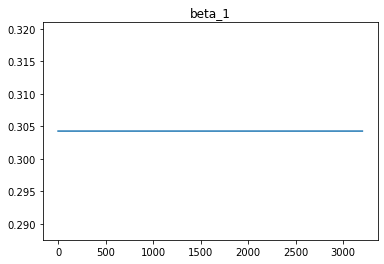

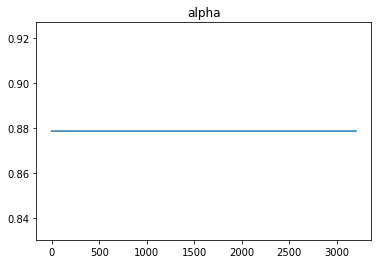

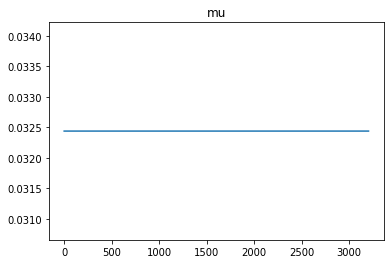

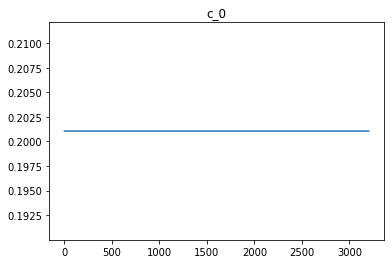

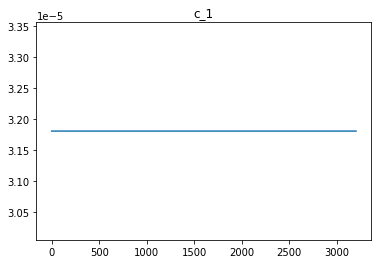

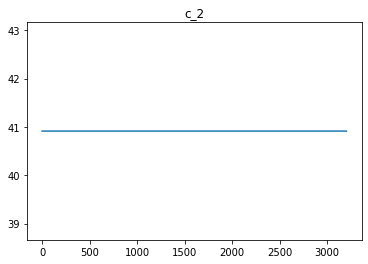

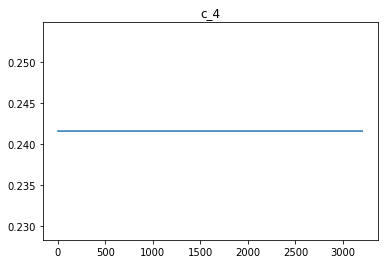

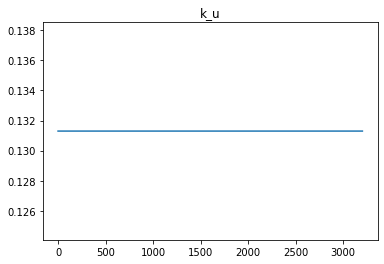

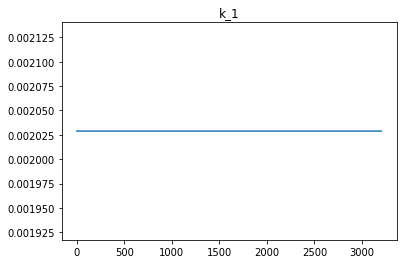

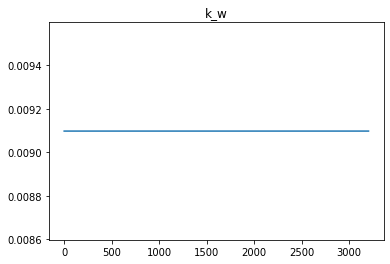

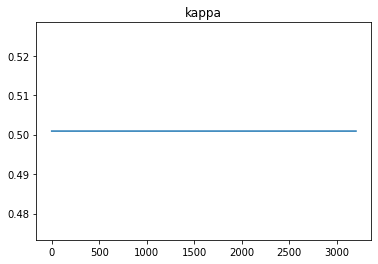

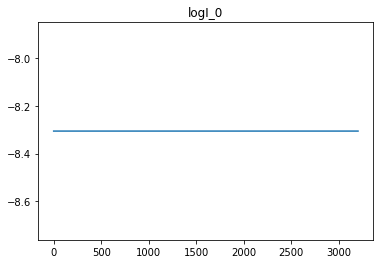

In [67]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0][1]]
print(pars)

for pp in pars:
    pt = [x[1][pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [27]:
pars = [x for x in MyModel.paramall[0][1]]
pars

['beta_1',
 'alpha',
 'mu',
 'c_0',
 'c_1',
 'c_2',
 'c_4',
 'k_u',
 'k_1',
 'k_w',
 'kappa',
 'logI_0']

In [33]:
MyModel.paramall[2][1]

name,value,standard error,relative error,initial value,min,max,vary
beta_1,0.38701404,7.5929e-04,(0.20%),0.38698789637875775,0.00000000,3.00000000,True
alpha,0.10798755,1.1738e-04,(0.11%),0.20898893851150524,0.00000000,1.00000000,True
mu,0.03234380,1.1152e-04,(0.34%),0.03125317394589683,0.00000000,0.50000000,True
c_0,0.11904659,0.02630128,(22.09%),0.15653613912876713,0.00000000,1.00000000,True
c_1,0.00136131,9.0875e-05,(6.68%),1.5261678587563665e-09,0.00000000,0.50000000,True
c_2,30.7311469,0.13184242,(0.43%),42.94417653164811,2.00000000,200.000000,True
c_4,0.49879124,0.01273355,(2.55%),0.043383448337693614,0.00000000,0.50000000,True
k_u,0.38704662,0.06184194,(15.98%),0.24145856916257885,0.00000000,1.00000000,True
k_1,6.5922e-05,0.00602224,(9135.43%),1.6332029472709841e-06,0.00000000,1.00000000,True
k_w,0.00264634,6.8892e-04,(26.03%),0.002145465202895047,0.00000000,1.00000000,True


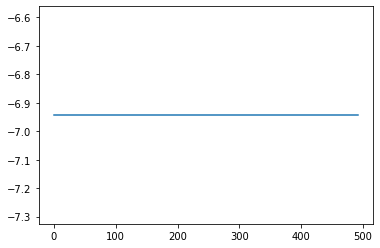

In [36]:
plt.plot([x[1]['logI_0'].value for x in MyModel.paramall]);

In [61]:
MyModel.fit_data

['confirmed_corrected_smoothed', 'deaths_corrected_smoothed']

In [67]:
MyModel.paramall[0][2]

name,value,standard error,relative error,initial value,min,max,vary
beta,0.30000000,0.33802791,(112.68%),0.4,0.30000000,0.80000000,True
alpha,0.00836407,0.01276560,(152.62%),0.2,0.00000000,1.00000000,True
mu,0.00161497,1.4415e-04,(8.93%),0.0032537960954446866,0.00000000,0.50000000,True
logI_0,-5.19495037,0.08105934,(1.56%),-6.522878745280337,-9.00000000,-3.00000000,True
